In [17]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs, survey_sim
from mejiro.instruments.roman import Roman

In [18]:
# band = 'F106'
band = 'F184'
psf_fwhm = Roman().get_psf_fwhm(band)

exposure_time = 146
grid_oversample = 1
input_size = 45
side = 0.11 * input_size
output_size = 45

print(f'side: {side}')

side: 4.95


PSF FWHM: 0.146


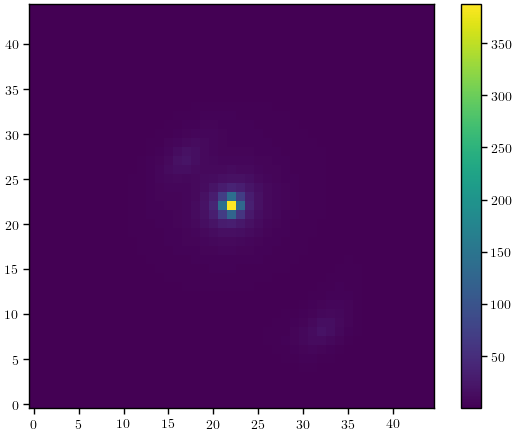

In [19]:
lens = SampleStrongLens()
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm}
print(f'PSF FWHM: {psf_fwhm}')

array = lens.get_array(num_pix=input_size, side=side, band=band, kwargs_psf=kwargs_psf)

plt.imshow(array)
plt.colorbar()
plt.show()

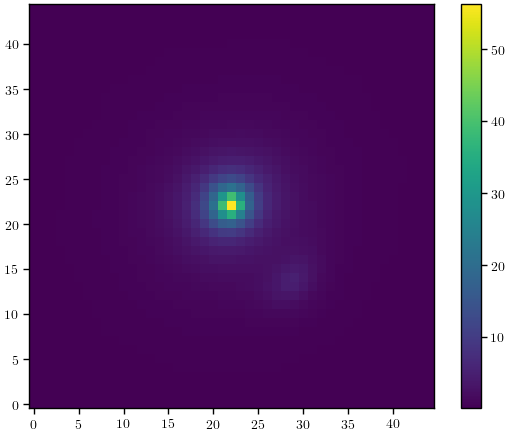

In [20]:
from lenstronomy.SimulationAPI.ObservationConfig import HST, LSST, Roman, DES, Euclid
from lenstronomy.SimulationAPI.sim_api import SimAPI
from copy import deepcopy

kwargs_model = lens.kwargs_model
kwargs_params = lens.kwargs_params

Roman_r = Roman.Roman(band=band.upper(), psf_type='PIXEL', survey_mode='wide_area')
Roman_r.obs['num_exposures'] = 1  # set number of exposures to 1 cf. 96
kwargs_r_band = Roman_r.kwargs_single_band()

sim_r = SimAPI(numpix=int(side / 0.11), kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model)

kwargs_numerics = {'point_source_supersampling_factor': 1, 'supersampling_factor': 3}
imSim_r = sim_r.image_model_class(kwargs_numerics)

kwargs_lens = kwargs_params['kwargs_lens']
kwargs_lens_light = kwargs_params['kwargs_lens_light']
kwargs_source = kwargs_params['kwargs_source']

kwargs_lens_light_r, kwargs_source_r, _ = sim_r.magnitude2amplitude(kwargs_lens_light, kwargs_source)

# set lens light to 0 for source image
source_kwargs_lens_light_r = deepcopy(kwargs_lens_light_r)
source_kwargs_lens_light_r[0]['amp'] = 0
source_surface_brightness = imSim_r.image(kwargs_lens, kwargs_source_r, source_kwargs_lens_light_r, None)

# set source light to 0 for lens image
lens_kwargs_source_r = deepcopy(kwargs_source_r)
lens_kwargs_source_r[0]['amp'] = 0
lens_surface_brightness = imSim_r.image(kwargs_lens, lens_kwargs_source_r, kwargs_lens_light_r, None)

total_image = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r, None)

plt.imshow(total_image)
plt.colorbar()
plt.show()

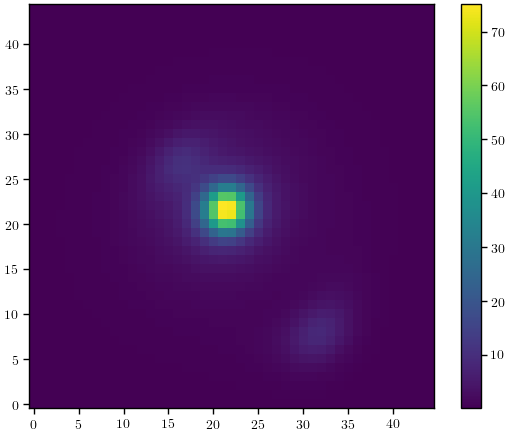

In [21]:
# get flux
total_flux_cps = lens.get_total_flux_cps(band)

# get interpolated image
interp = galsim.InterpolatedImage(galsim.Image(array, xmin=0, ymin=0), scale=0.11 / grid_oversample, flux=total_flux_cps * exposure_time)

# https://galsim-developers.github.io/GalSim/_build/html/composite.html#galsim.Convolve
convolved = galsim.Convolve([interp, galsim.Gaussian(flux=1., sigma=psf_fwhm)])

# draw interpolated image at the final pixel scale
im = galsim.ImageF(scale=0.11)  # NB setting dimensions to "input_size" because we'll crop down to "output_size" at the very end
im.setOrigin(0, 0)

image = convolved.drawImage(im)

# get the array
final_array = image.array

# center crop to get rid of edge effects (e.g., IPC)
final_array = util.center_crop_image(final_array, (output_size, output_size))

# divide through by exposure time to get in units of counts/sec/pixel
final_array /= exposure_time

plt.imshow(final_array)
plt.colorbar()
plt.show()